# data checks for Social Prediction

- figure out excluded subjects based on motion
- 

1. Task checks
- onsets, trial numbers

2. Behavioral checks
- missing trials?
- rating visuals

3. Scan QA
- motion, outlier visualizations from fmriprep
- signal to noise maps 
- Sanity check contrasts: video vs baseline


2022 Janurary 

In [19]:
import warnings
warnings.simplefilter('ignore')

# basic packages:
import glob
import numpy as np
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from nilearn import plotting, image

%matplotlib inline

from IPython.display import set_matplotlib_formats
# set to show vector images
set_matplotlib_formats('pdf', 'svg')

base_dir = '/work/abslab/AVFP/'


In [2]:
#['178', '168', '172', '173', '163', '164','148', '155']
# no social prediction task was collected or issue with scan 

excluded = []

# 1. Check tasks

In [3]:
# find all text files
logfiles_dir = '/work/abslab/Yiyu/SocialAbstraction/logfiles'
print('Fetching txt files from:',logfiles_dir)

my_files = glob.glob(logfiles_dir + "/*edited.txt")
n_sub= len(my_files)

Fetching txt files from: /work/abslab/Yiyu/SocialAbstraction/logfiles


In [4]:
print('\nFound **',n_sub,'** participant data files')


Found ** 36 ** participant data files


In [5]:
my_list = []
for filename in my_files:

    df = pd.read_csv(filename, index_col=None, header=None, delimiter=" ")
    
    # remove any extra columns:
    df = df.iloc[:,0:22]
    
    # add participant number
    ps_name = filename.split('_')[-2].split('.')[0]
    df["participant"] = ps_name
    # make sure everyone has unique video numbers
    print(len(np.unique(df.iloc[:,2])))
    # append to list
    my_list.append(df)

# concatenate across subjects
my_data = pd.concat(my_list, axis=0, ignore_index=True)

40
40
40
40
40
20
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40


In [6]:
# add column names:
col_names = ['obs_video_name', 'fd_video_name','video_number','trial_condition','run_number','run_condition',
             'obs_video_onset','obs_video_offset','obs_video_duration_method1','obs_video_duration_method2',
             'prediction','prediction_x','prediction_y','prediction_RT','prediction_onset', 
             'fb_video_onset','fb_video_offset','fb_video_duration_method1','fb_video_duration_method2',
             'surprise','surprise_RT','surprise_onset']
my_data.columns = col_names + ['participant']

In [7]:
# first count total number of trials per participant -- should be 40
n_videos = my_data.groupby(['participant']).count()[['video_number']]
n_videos_exclude = n_videos[n_videos.video_number != 40]
n_videos_exclude


Empty DataFrame
Columns: [video_number]
Index: []

In [8]:
print('this should be empty!')
print('everyone has 40 trials')


excluded.extend(n_videos_exclude.index.unique().tolist())
excluded = np.unique(excluded).tolist()

this should be empty!
everyone has 40 trials


# 2. Behavioral data checks

### missing response: 
how often do participants fail to responde for prediction, surprise

prediction: check x, y position and convert edge cases

# 3. Scan motion + FD

## Motion outlier

In [9]:
# TRs per scan run: 9min
nTR = 675 


# find all text files
confounds_dir = base_dir + 'fmriprep/*/fmriprep/sub-*/func/'

print('Fetching tsv files from:',confounds_dir)

my_files = glob.glob(confounds_dir + "*task-socialpred_run-[1|2]*.tsv")

print('\nFound **',len(my_files),'** tsv files for task-socialpred run 1 and 2')

Fetching tsv files from: /work/abslab/AVFP/fmriprep/*/fmriprep/sub-*/func/

Found ** 74 ** tsv files for task-socialpred run 1 and 2


In [10]:
my_list = []
outliers = pd.DataFrame(columns = ["participant", "run", "non_steady_state", "motion_outliers"])

n=-1
for filename in my_files:

    df = pd.read_csv(filename, index_col=None, delimiter="\t")
    
    if df.shape[0] != nTR:
        print(filename, ': nTRs !=', nTR, '-- check data!')
        
    # add run and subject number:
    ps = filename.split('sub-')[1][:3]
    run = filename.split('run-')[1][0]

    # count outliers (individual columns as regressors) to add to df
    n=n+1
    outliers.loc[n,"participant"] = ps
    outliers.loc[n,"run"] = run
    outliers.loc[n,"non_steady_state"] = len([i for i in df.columns.tolist() if "non_steady_state" in i])
    outliers.loc[n,"motion_outliers"] = len([i for i in df.columns.tolist() if "motion_outlier" in i])
    
    # select only the columns I need:
    df = df[['framewise_displacement','std_dvars','trans_x','trans_y','trans_z','rot_x','rot_y','rot_z']]

    df['participant'] = ps
    df['run'] = int(run)
    df['TR'] = list(range(df.shape[0]))
    
    # append to list
    my_list.append(df)

# concatenate across subjects
tsv_data = pd.concat(my_list, axis=0, ignore_index=True)

print('\n Found',len(tsv_data.participant.unique()),'participants with fmriprep tsv files')


 Found 37 participants with fmriprep tsv files


In [12]:
tsv_data.head()

framewise_displacement  std_dvars   trans_x   trans_y   trans_z     rot_x  \
0 NaN                     NaN         0.042612 -0.166562 -0.198625 -0.000247   
1  0.038996                1.155948   0.035612 -0.154813 -0.195961 -0.000267   
2  0.148937                1.188108   0.030347 -0.254367 -0.156435 -0.000266   
3  0.058108                1.106546   0.029515 -0.263105 -0.146668 -0.000630   
4  0.215516                1.199149  -0.007068 -0.158339 -0.143835 -0.000147   

      rot_y     rot_z participant  run  TR  
0 -0.000767  0.000983  142         1    0   
1 -0.000546  0.000873  142         1    1   
2 -0.000560  0.000949  142         1    2   
3 -0.000149  0.000950  142         1    3   
4  0.000009  0.000164  142         1    4

In [13]:
print('\nparticipants with > 5% outliers:')
outliers_exclude = outliers.loc[(outliers[['non_steady_state','motion_outliers']].sum(axis=1) / nTR) > .05,:]
outliers_exclude


participants with > 5% outliers:


participant run non_steady_state motion_outliers
57  175         2   1                57            
64  180         1   0                50            
65  180         2   1                104

In [14]:
# motion and rotation:
radian_thr = 0.026
trans_thr = 3

exc_sub = []
for confound in ['trans_x','trans_y','trans_z','rot_x','rot_y','rot_z']:
    for filename in my_files:

        df = pd.read_csv(filename, index_col=None, delimiter="\t")

        if df.shape[0] != nTR:
            print(filename, ': nTRs !=', nTR, '-- check data!')

        # add run and subject number:
        ps = filename.split('sub-')[1][:3]
        run = filename.split('run-')[1][0]
        

        max_value = np.around(np.nanmax(df[confound].values),trans_thr)
            
        #save exclusion:
        if 'trans' in confound:
            if max_value > trans_thr:
                print(confound)
                exc_sub.append(ps)  
                print(ps)
                print(run)
                print(max_value)

        elif 'rot' in confound:
            if max_value > radian_thr:
                print(confound)
                exc_sub.append(ps)  
                print(ps)
                print(run)
                print(max_value)





trans_x
165
2
3.355
trans_z
180
1
3.747
trans_z
184
2
7.946
rot_x
149
2
0.028
rot_x
175
2
0.058
rot_x
180
1
0.041
rot_x
184
2
0.073
rot_y
180
1
0.037
rot_z
147
2
0.038
rot_z
165
2
0.028


In [15]:
print(exc_sub)

['165', '180', '184', '149', '175', '180', '184', '180', '147', '165']


In [16]:
# update excluded list
excluded.extend(outliers_exclude.participant.unique().tolist())
excluded = np.unique(excluded).tolist()
excluded

['175', '180']

In [17]:
# re-arrange outliers df for plotting:
outliers = outliers.astype('int')
outliers_run1 = outliers[outliers.run == 1].drop(columns = "run")
outliers_run1.rename(columns={"non_steady_state": "nss_run1", "motion_outliers": "motion_run1"}, inplace=True)

outliers_run2 = outliers[outliers.run == 2].drop(columns = "run")
outliers_run2.rename(columns={"non_steady_state": "nss_run2", "motion_outliers": "motion_run2"}, inplace=True)

outliers = outliers_run1.merge(outliers_run2)


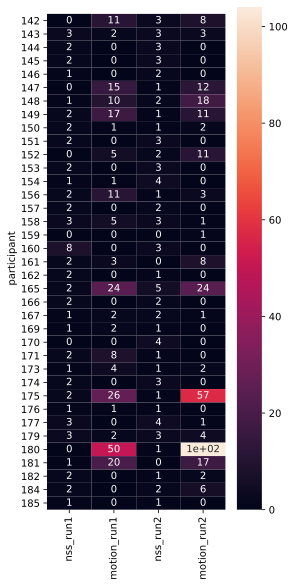

In [20]:
plt.figure(figsize=(4,len(tsv_data.participant.unique())/4))
sns.heatmap(outliers.set_index('participant'), annot=True)
plt.yticks(rotation=0)
plt.ylim(outliers.shape[0],-0.5)
plt.show()

# Framewise Displacement

In [21]:
# summary df by subject and run:
tsv_summary = tsv_data.groupby(['participant','run']).mean().drop(columns="TR")

print('\nparticipants with mean FD > .3:')
tsv_meanFD_outliers = tsv_summary.loc[tsv_summary.framewise_displacement > .3,:]
tsv_meanFD_outliers


participants with mean FD > .3:


framewise_displacement  std_dvars   trans_x   trans_y  \
participant run                                                          
180         1    0.338425                1.051531  -0.451883 -0.026428   
            2    0.374458                1.052352  -0.090037 -0.291717   

                  trans_z     rot_x     rot_y     rot_z  
participant run                                          
180         1    0.259925  0.001588  0.009941 -0.000792  
            2   -0.845462 -0.010732  0.003538 -0.002895

In [22]:
# update based on mean FD
excluded.extend(tsv_meanFD_outliers.reset_index().participant.unique().tolist())
excluded = np.unique(excluded).tolist()

In [23]:
tsv_max = tsv_data.groupby(['participant','run']).max().drop(columns="TR")

print('\nparticipants with a spike > 3mm:')
tsv_maxFD_outliers = tsv_max.loc[tsv_max.framewise_displacement > 3,:]
tsv_maxFD_outliers


participants with a spike > 3mm:


framewise_displacement  std_dvars   trans_x   trans_y  \
participant run                                                          
149         1    3.789775                2.546841   0.087455  0.124758   
165         2    3.246912                2.156099   3.355180  0.171295   
175         1    3.249398                3.246675   0.286949  0.242699   
180         1    5.430354                4.317474   0.872832  1.130140   
            2    3.902629                3.106677   0.590894  0.414958   
184         2    11.626840               8.400597   0.904298  1.908250   

                  trans_z     rot_x     rot_y     rot_z  
participant run                                          
149         1    1.042090  0.000794  0.025557  0.006172  
165         2    0.668074  0.002279  0.001154  0.028208  
175         1    2.528030  0.014704  0.001298  0.005287  
180         1    3.747210  0.041229  0.037111  0.017866  
            2    1.096120  0.011447  0.023650  0.001788  
184         2    7.946300  0.073414  0.016777  0.003587

In [ ]:
# count how many spike? Can it be fixed with despike?



In [24]:
# update based on mean FD
excluded.extend(tsv_maxFD_outliers.reset_index().participant.unique().tolist())
excluded = np.unique(excluded).tolist()

In [25]:
fig = px.line(tsv_data, x="TR", y="framewise_displacement", 
              color="participant", facet_row="run",
              width=1000, height=600,
              title="Framewise Displacement (FD). Outlier line --")
fig.add_hline(y=0.6, line_dash="dash") #spike line
fig.show()

# EXCLUDE THESE PARTICIPANTS FROM QA

In [131]:
total_sub = list(tsv_data.participant.unique())
included_sub = [x for x in total_sub if x not in excluded]
print('\nTotal **',len(total_sub),'** participants collected')
print('\nIncluded subjects: ',included_sub,'\n')


Total ** 35 ** participants collected

Included subjects:  ['152', '179', '154', '158', '173', '153', '159', '174', '162', '145', '143', '181', '144', '169', '146', '167', '161', '182', '147', '166', '160', '185', '170', '176', '151', '157', '171', '177', '150', '156'] 



In [132]:
print('\nExcluded subjects: ',excluded,'\n')


Excluded subjects:  ['149', '165', '175', '180', '184'] 



In [133]:
print('\nTotal included **',len(included_sub),'** participants data files')


Total included ** 30 ** participants data files


In [126]:
df = pd.DataFrame(included_sub)
df.to_csv(base_dir + "fmri_info/included_SocialPred_subjects.csv",index=False, header=False)

# QA: Sanity contrast: video vs Rating Period

In [3]:
import os

import glob
import nibabel as nib
import numpy as np
import pandas as pd
import copy

import nilearn
from nilearn import plotting, image
from nilearn.plotting import plot_glass_brain
from nilearn.plotting import plot_stat_map
from nilearn.plotting import plot_design_matrix
from nilearn.masking import apply_mask
from nilearn.input_data import NiftiMasker
from nilearn.glm.first_level import FirstLevelModel

from nilearn.glm.second_level import SecondLevelModel
from scipy.stats import norm


import gzip

import seaborn as sns
import matplotlib.pyplot as plt
from os.path import join

In [1]:
# local directory set up
#base_dir = '/Users/yiyuwang/Dropbox/Projects/SocialPrediction/'
#data_dir =base_dir + 'transformed_data_2mm/'

# directory set up for cluster:
base_dir = '/scratch/wang.yiyu/SocialAbstraction/'
data_dir = base_dir + 'transformed_data_2mm/'

logfiles_dir = base_dir + 'logfiles/'
confounds_dir = base_dir + 'confounds/'
mask_dir = base_dir + 'masks/'
figures_dir = base_dir + 'figures/'

#mask for 1st level:
mask_path = mask_dir +'MNI152_binary_T1_2mm_brain.nii.gz'
mask = nib.load(mask_path)


subjects_list = pd.read_csv(base_dir + 'fmri_info/included_SocialPred_subjects.csv', header=None)
subjects_list = subjects_list[0].values.tolist()
sample_n = len(subjects_list)
print("subjects in this analysis:")
print(subjects_list)
print(f"**** n = {sample_n} *****" )

TR = .001
N_TR = 675
TR_Length = 0.8
TR_IN_MS = int(TR_Length/TR)

fwhm = 6

mask = nib.load(mask_path)
# resample a gray matter mask
from nilearn import datasets
# gm_mask = datasets.fetch_icbm152_brain_gm_mask()
# gm_mask = mask_dir + 'mni_icbm152_nlin_sym_09a/mni_icbm152_gm_tal_nlin_sym_09a.nii.gz'
# gm_mask_img = resample_to_img(
#     gm_mask, mask, interpolation='nearest')

gm_mask_img = nib.load(mask_dir + 'gm_mask_icbm152_brain.nii.gz')
confounds_of_interest = ['csf',
                        'white_matter',
                        'trans_x', 
                        'trans_y', 
                        'trans_z',
                        'rot_x',
                        'rot_y',
                        'rot_z','framewise_displacement']




logfile_headers =np.array(['obs_video_name', 'fd_video_name','video_number','trial_condition','run_number','run_condition',
             'obs_video_onset','obs_video_offset','obs_video_duration_method1','obs_video_duration_method2',
             'prediction','prediction_x','prediction_y','prediction_RT','prediction_onset', 
             'fb_video_onset','fb_video_offset','fb_video_duration_method1','fb_video_duration_method2',
             'surprise','surprise_RT','surprise_onset'])


def AddSteadyStateOutliers(columns_of_interest, all_columns):
    new_columns = copy.deepcopy(columns_of_interest)
    for column in all_columns:
        if 'outlier' in column:
            new_columns.append(column)
            
    return new_columns


def AddVisualProperty(cov, s, run):
    new_cov = copy.deepcopy(cov)
    visual_reg = pd.read_csv(visual_reg_dir + f'subject_{s}_run_{run}.csv')
    new_cov = pd.concat([cov, visual_reg], axis =1)
    return new_cov

def CreateConfoundMatrix(confound_file_path, 
                         confounds_of_interest, s, run, add_vis=False):
    
    
    confounds = pd.read_csv(confound_file_path, sep='\t')
    
    confounds_of_interest = AddSteadyStateOutliers(confounds_of_interest, confounds.columns)
    
    cov = confounds[confounds_of_interest]
    if add_vis:
        cov = AddVisualProperty(cov, s, run)
    cov.values[np.isnan(cov.values)]=0
    return cov


def get_condition(cn):
    if cn == 1:
        cat = 'Pattern'
    elif cn == 2:
        cat = 'Social'
    else:
        print('no such Condition number!')
    return cat 


def parse_task_lines(lines, headers, model):
    dm_model = model
    for (i, line) in enumerate(lines):
        cols = line.split(' ')

        video_number = cols[int(np.where(headers == 'video_number')[0])]
        
        trial_condition = int(cols[int(np.where(headers == 'trial_condition')[0])])
        trial_condition = get_condition(trial_condition)
        
        run_condition = int(cols[int(np.where(headers == 'run_condition')[0])])
        run_condition = get_condition(run_condition)
        
        
        prediction_onset = float(cols[int(np.where(headers == 'prediction_onset')[0])])
        prediction_duration = 4
        
        surprise_onset = float(cols[int(np.where(headers == 'surprise_onset')[0])])
        surprise_duration = 4
  

        
        video_onset = float(cols[int(np.where(headers == 'obs_video_onset')[0])])
        video_offset = float(cols[int(np.where(headers == 'obs_video_offset')[0])])  
        video_duration = video_offset - video_onset
        
        fb_video_onset = float(cols[int(np.where(headers == 'fb_video_onset')[0])])
        fb_video_offset = float(cols[int(np.where(headers == 'fb_video_offset')[0])])  
        fb_video_duration = fb_video_offset - fb_video_onset

        run = int(cols[int(np.where(headers == 'run_number')[0])])
        surprise = abs(float(cols[int(np.where(headers == 'surprise')[0])]))

            
        if dm_model == 'VideoVRating':
            yield [video_onset, video_duration, 'obs_video', run]
            yield [fb_video_onset,fb_video_duration, 'fb_video', run]
            yield [prediction_onset, prediction_duration, 'pred_rating', run]
            yield [surprise_onset,surprise_duration, 'surprise_rating', run]

def create_events_dataframe(task_csv, run, model):   
    task_lines =[]       
    # df = pd.DataFrame(columns=['onset','duration','trial_type'])
    with open(task_csv, 'r') as task_csv_file:
        task_lines.append(list(parse_task_lines(task_csv_file.readlines()[0:], logfile_headers, model)))

    df = pd.DataFrame(task_lines[0], columns=['onset','duration','trial_type','run'])
    df= df[df['run']==run].drop(columns=['run'])
    return df

NameError: name 'nib' is not defined

In [5]:
dm_name = 'QA_VideoVRating'
res_dir = base_dir + f'fmri_results/{dm_name}/1stLvl/'
if not os.path.isdir(res_dir):
        os.mkdir(base_dir + f'fmri_results/{dm_name}/')
        os.mkdir(res_dir)


for s in subjects_list:
    print(f'running subject {s}')
        
    task_file = glob.glob(logfiles_dir + f"/*{s}*edited.txt")
    task_csv = task_file[0]
    
    for run in [1,2]:
        events = create_events_dataframe(task_csv, run, 'VideoVRating')
        ##get confounds info:
        confounds_str = f'sub-{s}_task-socialpred_run-{run}_desc-confounds_timeseries.tsv'
        cov = CreateConfoundMatrix(confounds_dir + confounds_str, confounds_of_interest, s, run)
        
        fmri_glm = FirstLevelModel(t_r=0.8,
                           noise_model='ar3',
                           standardize=True,
                           hrf_model='spm',
                           drift_model='cosine',
                           high_pass=.01, mask_img=gm_mask_img,smoothing_fwhm=8)
        
        func_str = f'sub-{s}_socialpred_run{run}.nii.gz'
        func_path = data_dir + func_str
        fmri_img = nib.load(func_path)
        fmri_glm = fmri_glm.fit(fmri_img, events, confounds=cov)
        
        # save design_matrix for every run
        design_matrix = fmri_glm.design_matrices_[0]

        plot_design_matrix(design_matrix, output_file=join(res_dir, f'design_matrix_run{run}.png'))
        contrast_matrix = np.eye(design_matrix.shape[1])
        #extract the betas
        for i in range(4):
            print(f'saving regressor for video {design_matrix.columns[i]}')
            eff = fmri_glm.compute_contrast(contrast_matrix[i],output_type='stat')
            nii_file_path = res_dir + f'/sub-{s}_run-{run}_beta_{design_matrix.columns[i]}_gm_masked.nii.gz'
            nib.save(eff, nii_file_path)
        
        
        

running subject 152
saving regressor for video fb_video
saving regressor for video obs_video
saving regressor for video pred_rating
saving regressor for video surprise_rating
saving regressor for video fb_video
saving regressor for video obs_video
saving regressor for video pred_rating
saving regressor for video surprise_rating
running subject 179
saving regressor for video fb_video
saving regressor for video obs_video
saving regressor for video pred_rating
saving regressor for video surprise_rating
saving regressor for video fb_video
saving regressor for video obs_video
saving regressor for video pred_rating
saving regressor for video surprise_rating
running subject 154
saving regressor for video fb_video
saving regressor for video obs_video
saving regressor for video pred_rating
saving regressor for video surprise_rating
saving regressor for video fb_video
saving regressor for video obs_video
saving regressor for video pred_rating
saving regressor for video surprise_rating
running su

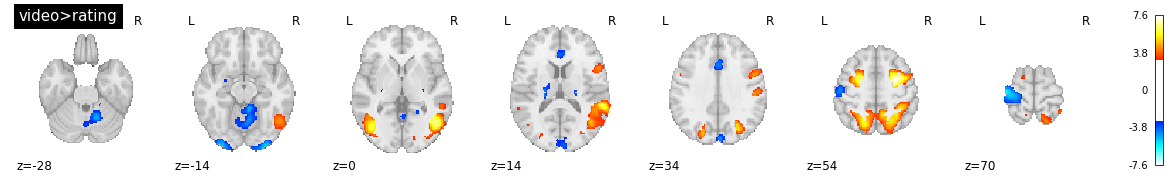

In [6]:
nifti_masker = NiftiMasker(mask_img = gm_mask_img)
file_list = []
PE_congruent_contrast = []
for s in subjects_list:
    file_name = glob.glob(res_dir + f'/sub-{s}*video*.nii.gz')
    file_list.append(file_name[0])
    PE_congruent_contrast.append(1)

            
for s in subjects_list:
    file_name = glob.glob(res_dir + f'/sub-{s}*rating*.nii.gz')
    file_list.append(file_name[0])
    PE_congruent_contrast.append(-1)




design_columns = ['intercept','video>rating']
X = pd.concat([pd.Series(np.ones(len(file_list))), pd.Series(PE_congruent_contrast)], axis=1)
X.columns= design_columns


second_level_input = file_list
second_level_model = SecondLevelModel()
second_level_model = second_level_model.fit(file_list, design_matrix=X)

z_map = second_level_model.compute_contrast('video>rating',output_type='z_score')

plotting.plot_stat_map(z_map, display_mode='z', threshold=3.2,
                               title= f'video>rating', colorbar=True)



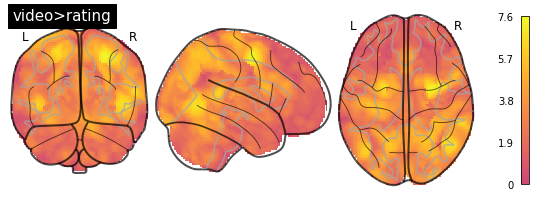

In [7]:
plotting.plot_glass_brain(z_map, title= f'video>rating', colorbar=True, cmap = 'plasma')

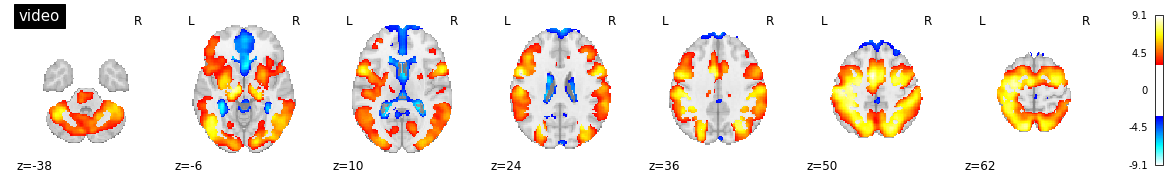

In [8]:
nifti_masker = NiftiMasker(mask_img = gm_mask_img)
file_list = []
PE_congruent_contrast = []
for s in subjects_list:
    file_name = glob.glob(res_dir + f'/sub-{s}*video*.nii.gz')
    file_list.append(file_name[0])


            


design_columns = ['intercept']
X = pd.DataFrame(np.ones(len(file_list)))
X.columns= design_columns


second_level_input = file_list
second_level_model = SecondLevelModel()
second_level_model = second_level_model.fit(file_list, design_matrix=X)

z_map = second_level_model.compute_contrast('intercept',output_type='z_score')

plotting.plot_stat_map(z_map, display_mode='z', threshold=3.2,
                               title= f'video', colorbar=True)



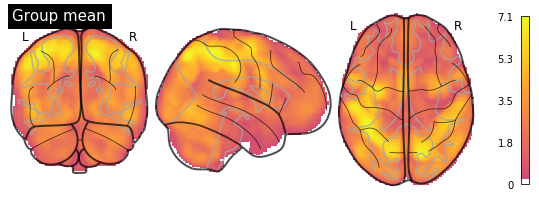

In [9]:
video_files = image.load_img(glob.glob(res_dir + '*video*nii.gz'))
rest_files = image.load_img(glob.glob(res_dir + '*rating*nii.gz'))

videos_images = image.smooth_img(video_files,4)
rest_images = image.smooth_img(rest_files,4)

plotting.plot_glass_brain(image.mean_img(videos_images), cmap="plasma", title='Group mean', colorbar=True)

# check one sample t-test for video_files




array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0

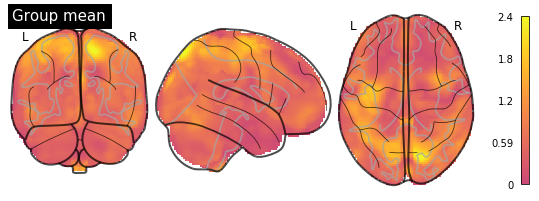

In [5]:
fb_video_files = image.load_img(glob.glob(res_dir + '*fb_video*nii.gz'))
plotting.plot_glass_brain(image.mean_img(fb_video_files), cmap="plasma", title='Group mean', colorbar=True)

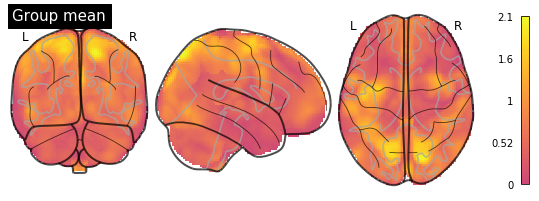

In [6]:
obs_video_files = image.load_img(glob.glob(res_dir + '*obs_video*nii.gz'))
plotting.plot_glass_brain(image.mean_img(obs_video_files), cmap="plasma", title='Group mean', colorbar=True)

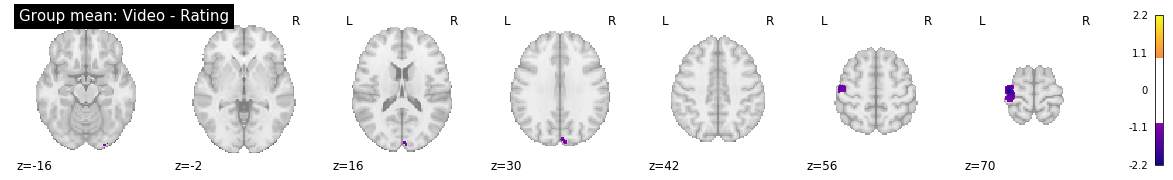

In [12]:
# the mean is small is probably because the random interval between a video and a rating period is short....


con_images = image.math_img('img1 - img2', img1 = videos_images, img2=rest_images)
group_con = image.mean_img(con_images)

plotting.view_img_on_surf(group_con, 
                          cmap="plasma", title='Group mean').resize(500,300)

plotting.plot_stat_map(group_con, cmap="plasma", display_mode='z', title='Group mean: Video - Rating', colorbar=True, threshold=1.6)

Sanity check: Visual cortex should be high in this contrast!

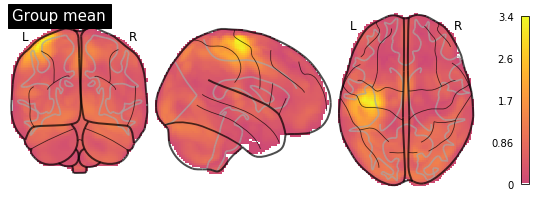

In [8]:
plotting.plot_glass_brain(image.mean_img(rest_images), cmap="plasma", title='Group mean: Rating period', colorbar=True)

Sanity check: left motor area for using the track ball